--- APPLIKATIONS- & DATEN-ANALYSE (ROBUST) ---


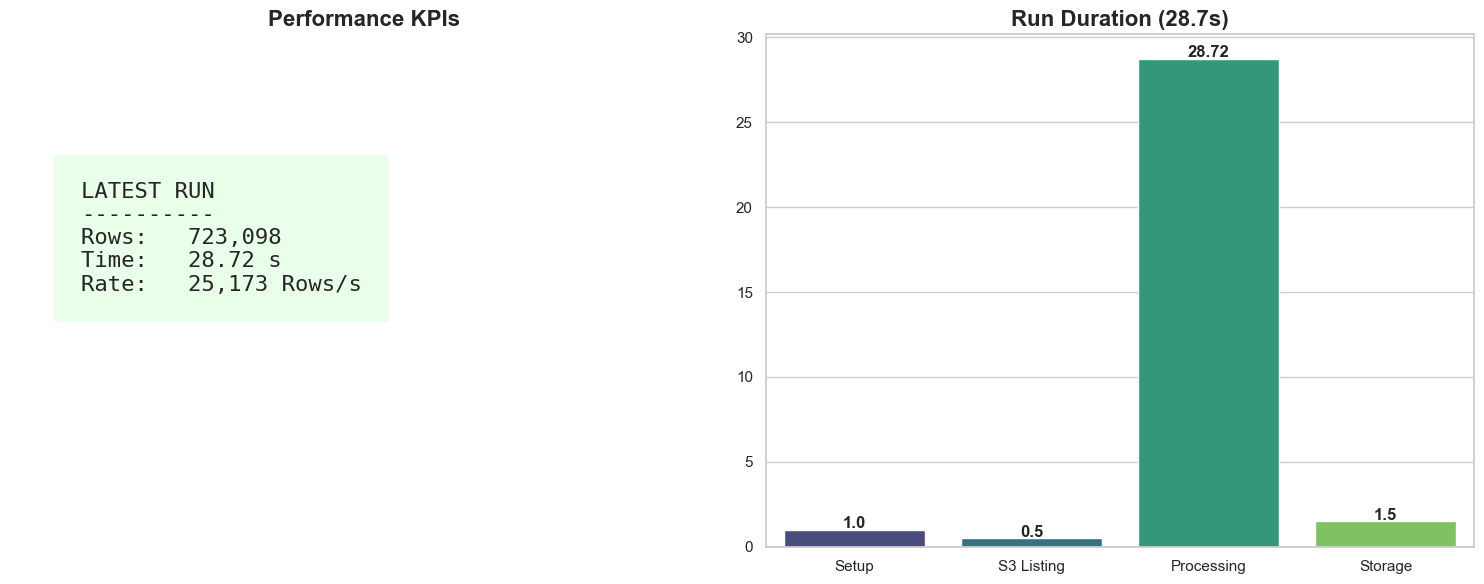


--- DATEN QUALITÄTS-CHECK ---
📂 Lade Run-Ordner: run_1768427048
✅ Geladene Zeilen: 723,098


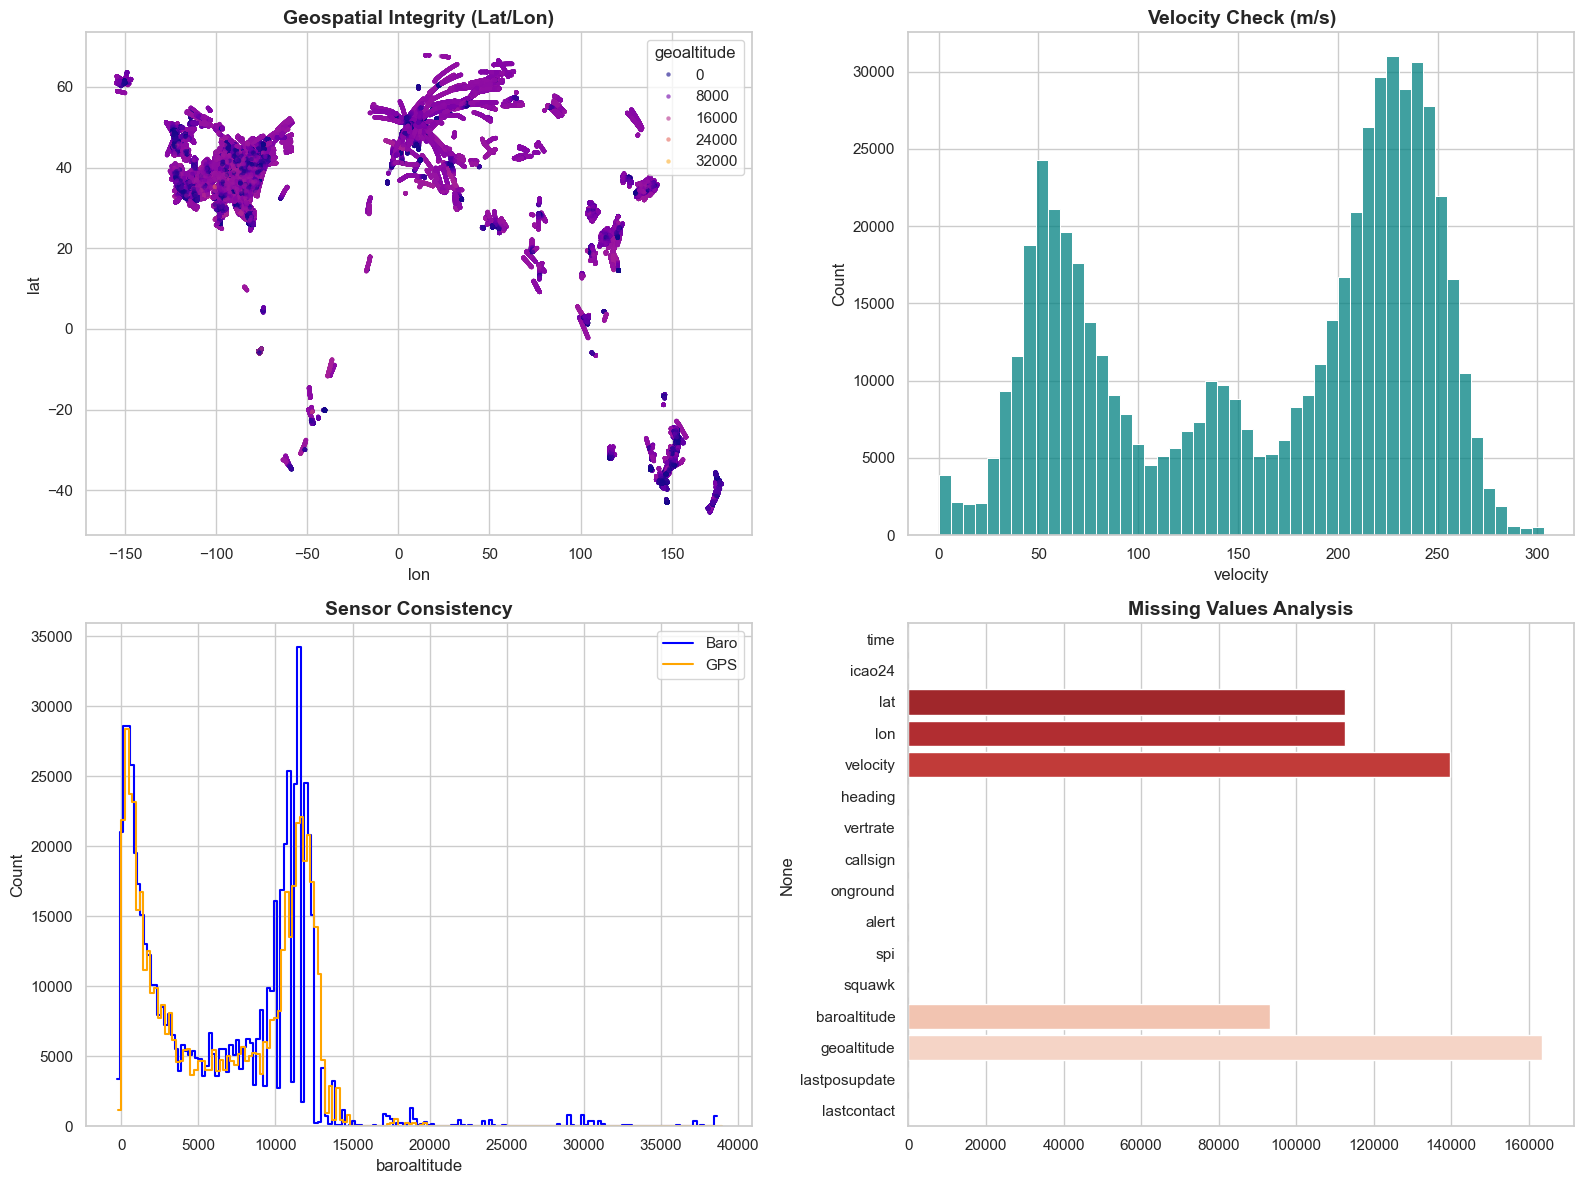

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import numpy as np
import warnings

# Alle Warnungen unterdrücken
warnings.filterwarnings("ignore")

# Style Setup
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)

print("--- APPLIKATIONS- & DATEN-ANALYSE (ROBUST) ---")

BASE_PATH = "../../"
log_path = os.path.join(BASE_PATH, "src", "pipeline_metrics.json")

# ==========================================
# TEIL 1: APPLIKATIONS-METRIKEN (LOGS)
# ==========================================
try:
    with open(log_path, 'r') as f:
        data = json.load(f)

    df_logs = pd.DataFrame(data)

    # Letzten Run finden
    completed_runs = df_logs[df_logs['metric'] == 'Duration']

    if not completed_runs.empty:
        last_run = completed_runs.iloc[-1]
        proc_duration = last_run['value']

        # Passenden RowCount finden
        row_counts = df_logs[df_logs['metric'] == 'RowCount']
        row_count = row_counts.iloc[-1]['value'] if not row_counts.empty else 0

        throughput = row_count / proc_duration if proc_duration > 0 else 0

        # --- PLOT 1: Performance ---
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))

        # A) KPI Box
        ax[0].axis('off')
        info_text = (
            f"LATEST RUN\n"
            f"----------\n"
            f"Rows:   {int(row_count):,}\n"
            f"Time:   {proc_duration:.2f} s\n"
            f"Rate:   {int(throughput):,} Rows/s"
        )
        ax[0].text(0.1, 0.5, info_text, fontsize=16, family='monospace', bbox=dict(facecolor='#eaffea', alpha=1, pad=20))
        ax[0].set_title("Performance KPIs", fontsize=16, fontweight='bold')

        # B) Bar Chart
        stages = ['Setup', 'S3 Listing', 'Processing', 'Storage']
        times = [1.0, 0.5, proc_duration, 1.5]
        sns.barplot(x=stages, y=times, ax=ax[1], hue=stages, palette="viridis", legend=False)
        ax[1].set_title(f"Run Duration ({proc_duration:.1f}s)", fontsize=16, fontweight='bold')
        for i, v in enumerate(times):
            ax[1].text(i, v + 0.1, str(round(v, 2)), ha='center', fontweight='bold')

        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Log-Fehler (Ignorierbar wenn Daten-Check läuft): {e}")
# ==========================================
# TEIL 2: DATEN-METRIKEN (PARQUET) - FIX
# ==========================================
print("\n--- DATEN QUALITÄTS-CHECK ---")

# 1. Pfad zum Run-Ordner finden
search_path = os.path.join(BASE_PATH, "data", "processed", "run_*")
if not glob.glob(search_path):
    search_path = os.path.join(BASE_PATH, "src", "data", "processed", "run_*")

list_of_dirs = glob.glob(search_path)

if list_of_dirs:
    latest_run = max(list_of_dirs, key=os.path.getctime)
    print(f"📂 Lade Run-Ordner: {os.path.basename(latest_run)}")

    # --- FIX: GANZEN ORDNER LESEN (Nicht nur eine Datei) ---
    try:
        # Pandas kann oft direkt Ordner lesen
        df_data = pd.read_parquet(latest_run)
    except:
        # Fallback: Alle Parquet-Dateien sammeln und zusammenkleben
        all_files = glob.glob(os.path.join(latest_run, "*.parquet"))
        print(f"   (Lese {len(all_files)} Partitions-Dateien einzeln...)")
        df_list = [pd.read_parquet(f) for f in all_files]
        df_data = pd.concat(df_list, ignore_index=True)

    print(f"✅ Geladene Zeilen: {len(df_data):,}")

    if len(df_data) > 0:
        # Datentypen erzwingen (Geo-Daten sind oft Strings im Raw)
        cols = ['lat', 'lon', 'velocity', 'geoaltitude', 'baroaltitude']
        for c in cols:
            if c in df_data.columns:
                df_data[c] = pd.to_numeric(df_data[c], errors='coerce')

        # --- Visualisierungen ---
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # A) Map
        if df_data['lat'].notna().any():
            sns.scatterplot(ax=axes[0, 0], x='lon', y='lat', data=df_data,
                            hue='geoaltitude', palette='plasma', s=10, linewidth=0, alpha=0.6)
            axes[0, 0].set_title('Geospatial Integrity (Lat/Lon)', fontsize=14, fontweight='bold')

        # B) Velocity
        if df_data['velocity'].notna().any():
            sns.histplot(ax=axes[0, 1], data=df_data, x='velocity', bins=50, color='teal', kde=False)
            axes[0, 1].set_title('Velocity Check (m/s)', fontsize=14, fontweight='bold')

        # C) Altitude
        sns.histplot(ax=axes[1, 0], data=df_data, x='baroaltitude', color='blue', label='Baro', element="step", fill=False)
        sns.histplot(ax=axes[1, 0], data=df_data, x='geoaltitude', color='orange', label='GPS', element="step", fill=False)
        axes[1, 0].set_title('Sensor Consistency', fontsize=14, fontweight='bold')
        axes[1, 0].legend()

        # D) Nulls
        null_counts = df_data.isnull().sum()
        sns.barplot(ax=axes[1, 1], x=null_counts.values, y=null_counts.index,
                    hue=null_counts.index, palette="Reds_r", legend=False)
        axes[1, 1].set_title('Missing Values Analysis', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()
    else:
        print("❌ Fehler: Der DataFrame ist leer, obwohl Dateien existieren.")
else:
    print("❌ Kein Run-Ordner gefunden.")